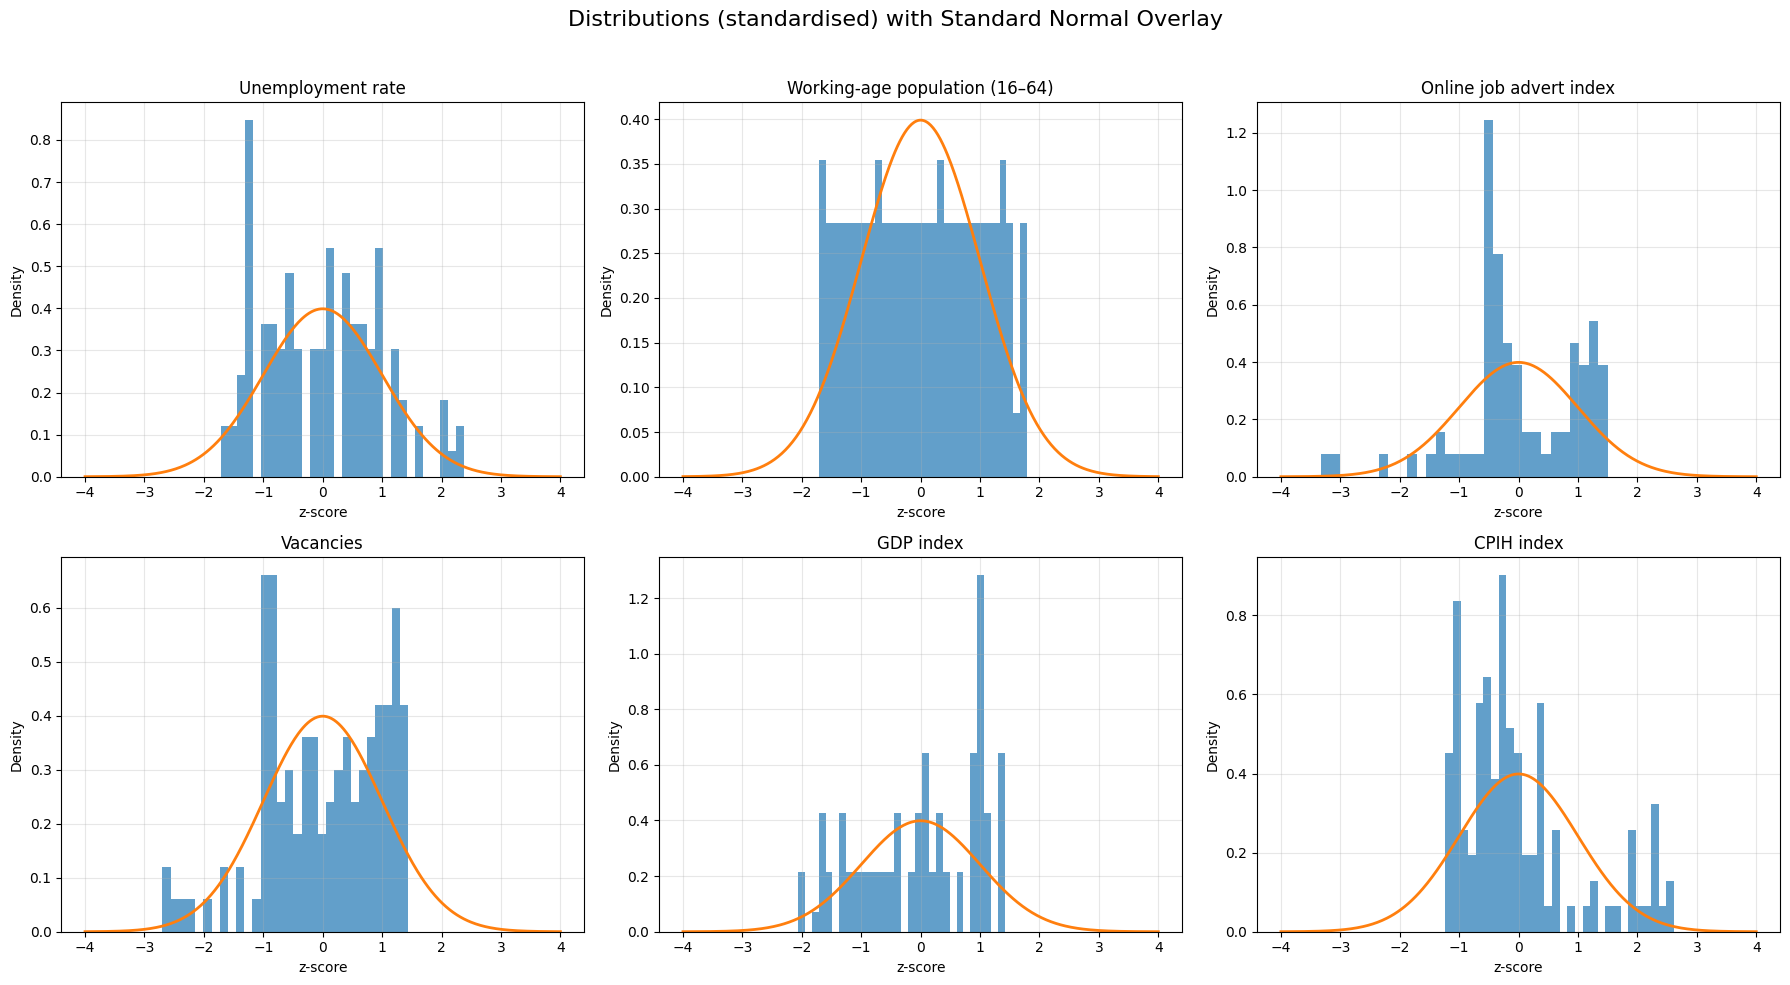

Saved: pic2/EDA_Distributions_Z_NormalOverlay.png


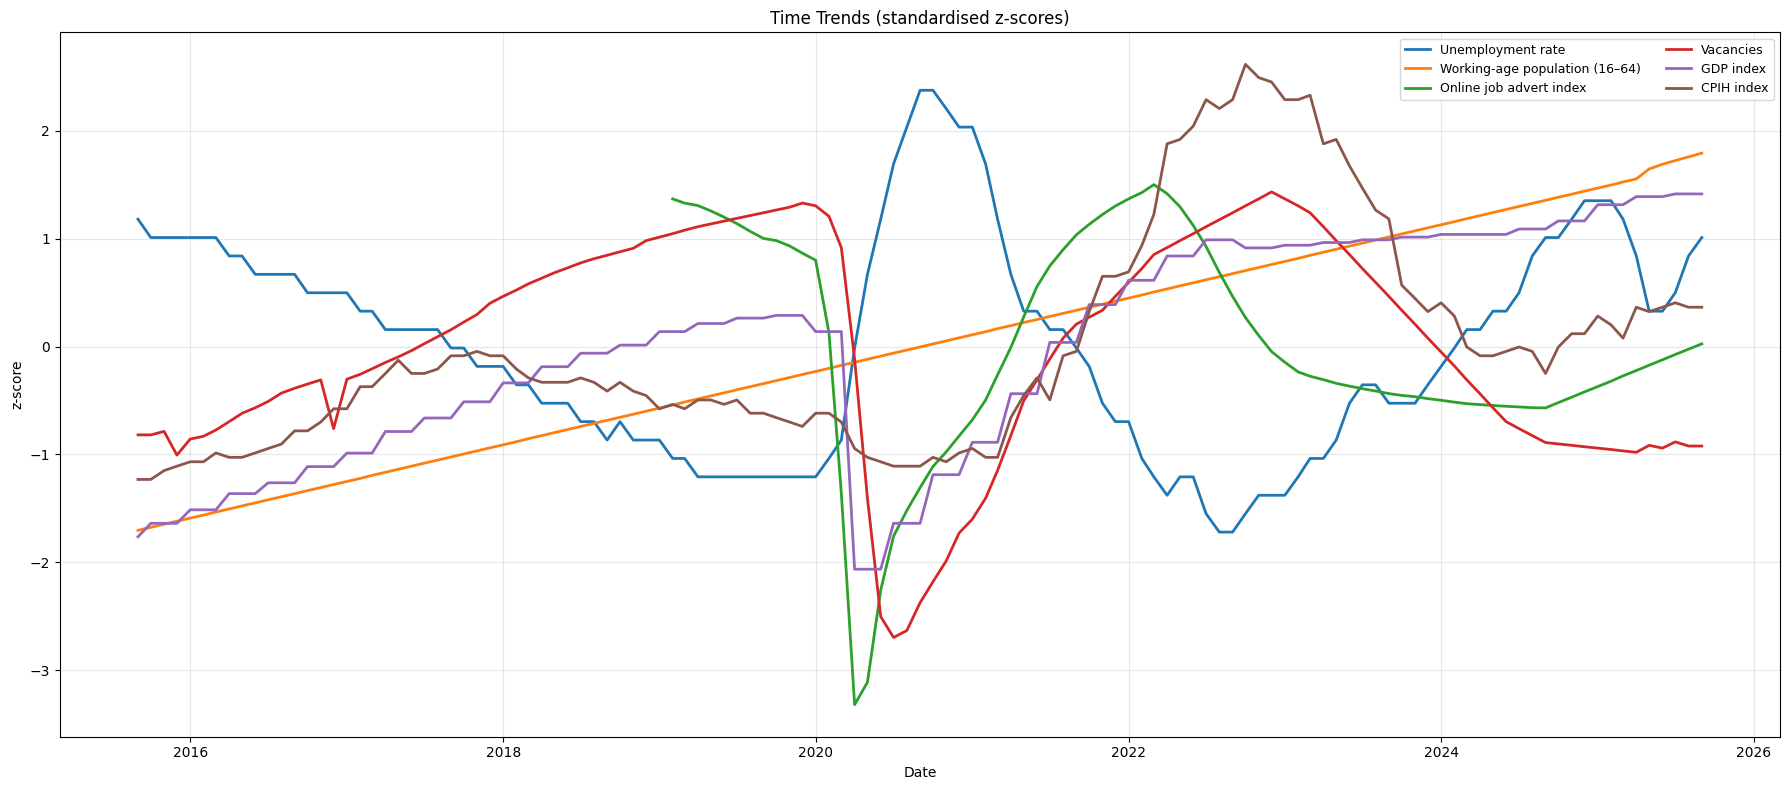

Saved: pic2/EDA_Trends_Z_AllSeries.png


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# =============================
# 0) Paths (use your uploaded files in /mnt/data)
# =============================
FILES = [
    ("using_data_csv/失业率（15-25）.csv",        "Unemployment rate"),
    ("using_data_csv/劳动人口数量（15-25）.csv",    "Working-age population (16–64)"),
    ("using_data_csv/招聘指数_补全至2025-09.csv",   "Online job advert index"),
    ("using_data_csv/职位空缺（15-25）.csv",       "Vacancies"),
    ("using_data_csv/GDP指数（15-25）.csv",        "GDP index"),
    ("using_data_csv/CPIH消费者物价指数（15-25）.csv","CPIH index"),
]

OUT_DIR = "pic2"
os.makedirs(OUT_DIR, exist_ok=True)

# =============================
# 1) Helper: read each CSV as (date, value)
#    - robustly detects the numeric column (ignores date column)
# =============================
def read_ts(path: str, name: str) -> pd.DataFrame:
    df = pd.read_csv(path)

    # find date column
    date_col = None
    for c in df.columns:
        if c.lower() in ["date", "time", "month", "period"]:
            date_col = c
            break
    if date_col is None:
        raise ValueError(f"[{name}] Cannot find a date column in {path}. Columns={list(df.columns)}")

    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df = df.dropna(subset=[date_col]).sort_values(date_col)

    # find numeric value column (first numeric-like column excluding date)
    candidates = [c for c in df.columns if c != date_col]
    num_col = None
    for c in candidates:
        s = pd.to_numeric(df[c], errors="coerce")
        if s.notna().sum() >= max(10, int(0.5 * len(df))):  # enough numeric values
            num_col = c
            df[c] = s
            break
    if num_col is None:
        raise ValueError(f"[{name}] Cannot find a numeric value column in {path}. Columns={list(df.columns)}")

    out = df[[date_col, num_col]].rename(columns={date_col: "date", num_col: name})
    return out

# =============================
# 2) Read + merge (monthly window)
# =============================
series_list = [read_ts(p, n) for p, n in FILES]

df_all = series_list[0]
for d in series_list[1:]:
    df_all = df_all.merge(d, on="date", how="outer")

df_all = df_all.sort_values("date").set_index("date")

# keep your main window
START, END = "2015-09-01", "2025-09-01"
df_all = df_all.loc[START:END]

# =============================
# 3) Figure 1: Distributions (z-score) + standard normal curve
#    - Each subplot: histogram of z + N(0,1) PDF overlay
# =============================
cols = df_all.columns.tolist()
n = len(cols)
ncols = 3
nrows = int(np.ceil(n / ncols))

fig1, axes = plt.subplots(nrows, ncols, figsize=(18, 10))
axes = np.array(axes).reshape(-1)

xgrid = np.linspace(-4, 4, 400)
pdf = norm.pdf(xgrid, loc=0, scale=1)

for i, col in enumerate(cols):
    ax = axes[i]
    x = df_all[col].dropna().values

    if len(x) < 5:
        ax.set_title(f"{col}\n(not enough data)")
        ax.axis("off")
        continue

    mu, sd = np.mean(x), np.std(x, ddof=1)
    if sd == 0 or np.isnan(sd):
        ax.set_title(f"{col}\n(constant/invalid)")
        ax.axis("off")
        continue

    z = (x - mu) / sd

    ax.hist(z, bins=30, density=True, alpha=0.7)
    ax.plot(xgrid, pdf, linewidth=2)

    ax.set_title(col)
    ax.set_xlabel("z-score")
    ax.set_ylabel("Density")
    ax.grid(True, alpha=0.3)

# turn off unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

fig1.suptitle("Distributions (standardised) with Standard Normal Overlay", fontsize=16)
fig1.tight_layout(rect=[0, 0, 1, 0.96])

out1 = os.path.join(OUT_DIR, "EDA_Distributions_Z_NormalOverlay.png")
fig1.savefig(out1, dpi=200)
plt.show()

print("Saved:", out1)

# =============================
# 4) Figure 2: Trends over time (standardised) — all lines in one chart
#    - z-score each series to make them comparable on one axis
# =============================
df_z = df_all.copy()
for col in df_z.columns:
    s = df_z[col]
    df_z[col] = (s - s.mean()) / s.std(ddof=1)

fig2 = plt.figure(figsize=(18, 8))
for col in df_z.columns:
    plt.plot(df_z.index, df_z[col], linewidth=2, label=col)

plt.title("Time Trends (standardised z-scores)")
plt.xlabel("Date")
plt.ylabel("z-score")
plt.grid(True, alpha=0.3)
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()

out2 = os.path.join(OUT_DIR, "EDA_Trends_Z_AllSeries.png")
plt.savefig(out2, dpi=200)
plt.show()

print("Saved:", out2)


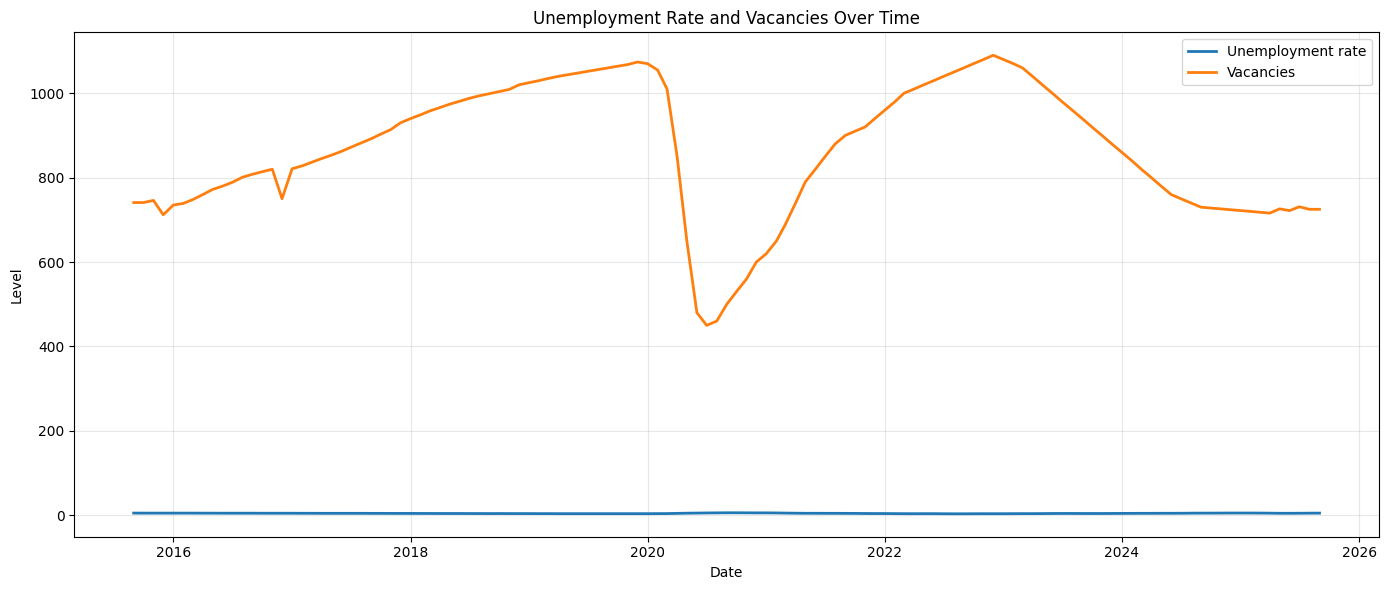

Saved: pic2/EDA_Unemployment_vs_Vacancies_levels.png


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# =============================
# 0) Paths
# =============================
PATH_UNEMP = "using_data_csv/失业率（15-25）.csv"
PATH_VAC   = "using_data_csv/职位空缺（15-25）.csv"

OUT_DIR = "pic2"
os.makedirs(OUT_DIR, exist_ok=True)

# =============================
# 1) Read data (date + value)
# =============================
unemp = pd.read_csv(PATH_UNEMP)
vac = pd.read_csv(PATH_VAC)

# 自动识别 date / value 列
def tidy_ts(df, value_name):
    date_col = [c for c in df.columns if c.lower() in ["date", "time", "month"]][0]
    value_col = [c for c in df.columns if c != date_col][0]
    df = df[[date_col, value_col]].rename(
        columns={date_col: "date", value_col: value_name}
    )
    df["date"] = pd.to_datetime(df["date"])
    return df.sort_values("date")

unemp = tidy_ts(unemp, "Unemployment rate")
vac = tidy_ts(vac, "Vacancies")

# 合并
df = pd.merge(unemp, vac, on="date", how="inner")

# 时间范围（与你论文一致）
df = df[(df["date"] >= "2015-09-01") & (df["date"] <= "2025-09-01")]

# =============================
# 2) Plot: two time series
# =============================
plt.figure(figsize=(14, 6))

plt.plot(
    df["date"],
    df["Unemployment rate"],
    linewidth=2,
    label="Unemployment rate"
)

plt.plot(
    df["date"],
    df["Vacancies"],
    linewidth=2,
    label="Vacancies"
)

plt.xlabel("Date")
plt.ylabel("Level")
plt.title("Unemployment Rate and Vacancies Over Time")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

out_path = os.path.join(OUT_DIR, "EDA_Unemployment_vs_Vacancies_levels.png")
plt.savefig(out_path, dpi=200)
plt.show()

print("Saved:", out_path)


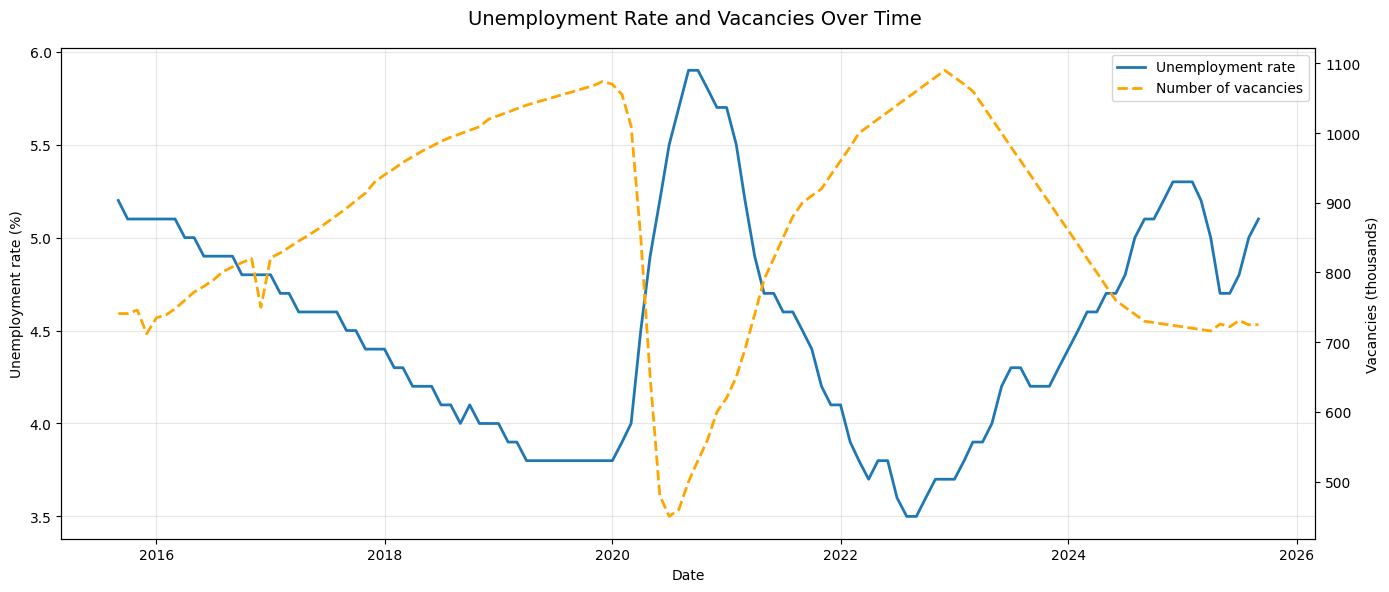

Saved: pic2/EDA_Unemployment_vs_Vacancies_twin_axis.png


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# =============================
# 0) Paths
# =============================
PATH_UNEMP = "using_data_csv/失业率（15-25）.csv"
PATH_VAC   = "using_data_csv/职位空缺（15-25）.csv"

OUT_DIR = "pic2"
os.makedirs(OUT_DIR, exist_ok=True)

# =============================
# 1) Read data (date + value)
# =============================
def tidy_ts(path, value_name):
    df = pd.read_csv(path)
    date_col = [c for c in df.columns if c.lower() in ["date", "time", "month"]][0]
    value_col = [c for c in df.columns if c != date_col][0]
    df = df[[date_col, value_col]].rename(
        columns={date_col: "date", value_col: value_name}
    )
    df["date"] = pd.to_datetime(df["date"])
    return df.sort_values("date")

unemp = tidy_ts(PATH_UNEMP, "Unemployment rate")
vac   = tidy_ts(PATH_VAC, "Vacancies")

df = pd.merge(unemp, vac, on="date", how="inner")
df = df[(df["date"] >= "2015-09-01") & (df["date"] <= "2025-09-01")]

# =============================
# 2) Twin y-axis plot
# =============================
fig, ax1 = plt.subplots(figsize=(14, 6))

# Left y-axis: unemployment
ax1.plot(
    df["date"],
    df["Unemployment rate"],
    linewidth=2,
    label="Unemployment rate"
)
ax1.set_xlabel("Date")
ax1.set_ylabel("Unemployment rate (%)")
ax1.tick_params(axis="y")

# Right y-axis: vacancies
ax2 = ax1.twinx()
ax2.plot(
    df["date"],
    df["Vacancies"],
    linewidth=2,
    color="orange",
    linestyle="--",
    label="Number of vacancies"
)
ax2.set_ylabel("Vacancies (thousands)")
ax2.tick_params(axis="y")

# Title
fig.suptitle("Unemployment Rate and Vacancies Over Time", fontsize=14)

# Legend (merge both axes)
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(
    lines_1 + lines_2,
    labels_1 + labels_2,
    loc="upper right"
)

ax1.grid(True, alpha=0.3)
fig.tight_layout()

out_path = os.path.join(OUT_DIR, "EDA_Unemployment_vs_Vacancies_twin_axis.png")
plt.savefig(out_path, dpi=200)
plt.show()

print("Saved:", out_path)


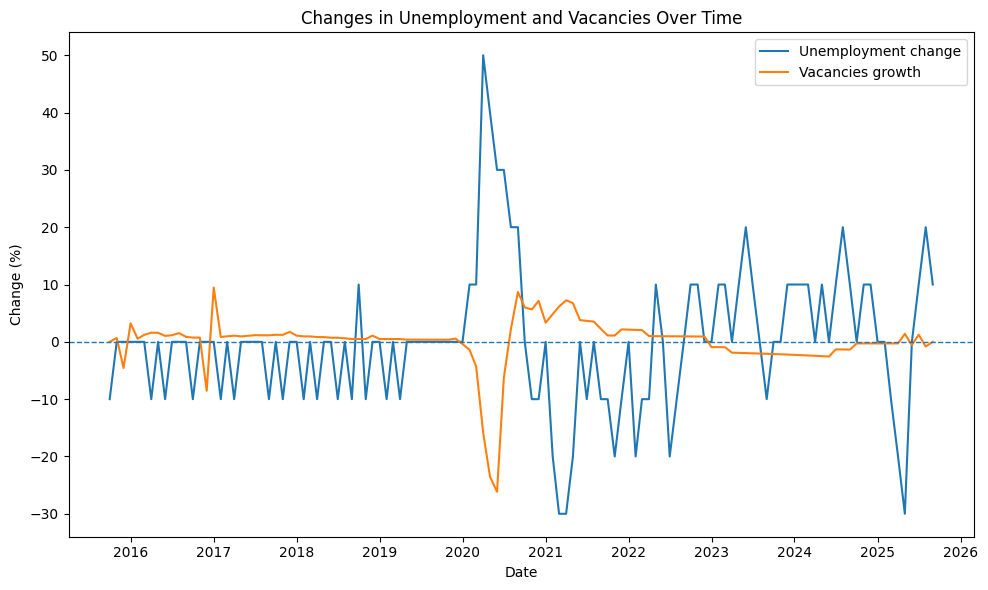

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# =============================
# 1. 读取数据
# =============================
unemp = pd.read_csv(
    "using_data_csv/失业率（15-25）.csv",
    parse_dates=["date"]
).rename(columns={"rate": "unemployment"})

vac = pd.read_csv(
    "using_data_csv/职位空缺（15-25）.csv",
    parse_dates=["date"]
).rename(columns={"value": "vacancies"})

# =============================
# 2. 合并数据并排序
# =============================
df = pd.merge(unemp, vac, on="date", how="inner")
df = df.sort_values("date")

# =============================
# 3. 构造变化率变量
# =============================
# 失业率：用“变化量”（百分点变化）
df["unemployment_change"] = df["unemployment"].diff() * 100

# 职位空缺：用“增长率”（百分比变化）
df["vacancies_growth"] = df["vacancies"].pct_change() * 100

# 删除缺失值
df = df.dropna()

# =============================
# 4. 可视化：变化率折线图
# =============================
plt.figure(figsize=(10, 6))

plt.plot(
    df["date"],
    df["unemployment_change"],
    label="Unemployment change"
)

plt.plot(
    df["date"],
    df["vacancies_growth"],
    label="Vacancies growth"
)

plt.axhline(0, linestyle="--", linewidth=1)

plt.xlabel("Date")
plt.ylabel("Change (%)")
plt.title("Changes in Unemployment and Vacancies Over Time")
plt.legend()
plt.tight_layout()

out_path = os.path.join(OUT_DIR, "1.png")
plt.savefig(out_path, dpi=200)

plt.show()
